In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import itertools 
import scipy
import matplotlib
import glob
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scipy.io as sio
import matplotlib.mlab as mlab

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
DATA_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB361/'
local_gene_df = pd.read_csv(DATA_DIR + 'MB361_local_hit.csv', skip_blank_lines=True, )

In [3]:
local_gene_df.columns = [
        'idx', 'gene_names', 'chromosome', 'pos', 'strand', 
        'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
        'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [4]:
local_gene_df

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,distance,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
0,46231,KRT12,chr17,2531647772,-,0,16,chr17:42823979-42824479,1956769,766,800,-inf,0.737038,-inf,NaN
1,46232,KRT20,chr17,2531665789,-,0,16,chr17:42823979-42824479,1938752,766,800,-inf,0.271168,NaN,0.000000
2,46233,AC004231.2,chr17,2531701992,+,0,16,chr17:42823979-42824479,1902549,766,800,-inf,0.420826,NaN,0.000000
3,46234,KRT23,chr17,2531718196,-,0,16,chr17:42823979-42824479,1886345,766,800,-0.697951,0.806770,NaN,0.752797
4,46236,KRT40,chr17,2531767697,-,0,16,chr17:42823979-42824479,1836844,766,800,-inf,0.870389,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143597,1747,RP4-794H19.4,chr1,58933643,+,0,0,chr1:58575877-58576377,357766,912,900,-inf,0.749443,-inf,NaN
143598,1748,RP4-794H19.3,chr1,58999676,+,0,0,chr1:58575877-58576377,423799,912,900,-inf,0.926924,-inf,NaN
143599,1751,RP11-470E16.1,chr1,59208121,-,0,0,chr1:58575877-58576377,632244,912,900,-inf,0.799852,-inf,NaN
143600,1720,PRKAA2,chr1,56645322,+,0,0,chr1:58575877-58576377,1930555,912,900,-0.144495,0.879081,-1.199197,0.892645


In [13]:
filter_local_df = local_gene_df[(local_gene_df['padj-Gaussian'] < -15) & \
                                (local_gene_df['fc_by_rand_dist_cpm'] < 0.75) & \
                                (local_gene_df['num_cell'] > 700) & \
                                (local_gene_df['fc_by_rand_dist_cpm'] != 0)].sort_values(by='padj-Gaussian')

In [14]:
filter_local_df

,idx,gene_names,chromosome,pos,strand,color_idx,chr_idx,region,distance,num_cell,bin,pval,fc,padj-Gaussian,fc_by_rand_dist_cpm
92483,1287,CITED4,chr1,40862366,-,0,0,chr1:40862276-40862776,90,1476,1500,-2.509728,0.874915,-6.845482e+06,0.732475
121738,1287,CITED4,chr1,40862366,-,0,0,chr1:40919322-40919917,56956,1374,1400,-2.417686,0.790645,-4.287301e+05,0.662337
132683,30306,IFITM3,chr11,1809008588,-,0,10,chr11:320278-320778,7259,1764,1800,-130.374236,0.409566,-3.484352e+05,0.416381
32708,3281,PMVK,chr1,154936991,-,0,0,chr1:154936783-154937283,208,1362,1400,-25.152860,0.657398,-3.223401e+05,0.616871
96482,42259,HAGHL,chr16,2401169153,+,1,15,chr16:726229-726752,707,1087,1100,-6.733912,0.783189,-6.180115e+04,0.694453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43287,48940,KISS1R,chr19,2655328575,+,0,18,chr19:459516-460120,457771,1115,1100,-3.840005,0.590640,-1.510897e+01,0.548770
71507,18123,BTN2A1,chr6,1087656228,+,1,5,chr6:26457686-26458186,218,1406,1400,-2.695434,0.729192,-1.504333e+01,0.727862
33877,51657,ZSCAN5A,chr19,2710779671,-,0,18,chr19:57803578-57804141,1435195,1157,1200,-4.789457,0.525544,-1.504106e+01,0.557160
114764,3240,RP11-422P24.12,chr1,153964361,+,0,0,chr1:153633698-153634232,330663,992,1000,-3.682290,0.519316,-1.502324e+01,0.498757


In [15]:
filter_local_df.to_csv('./MB361-filter_local_df.csv')

## Volcano plots
___

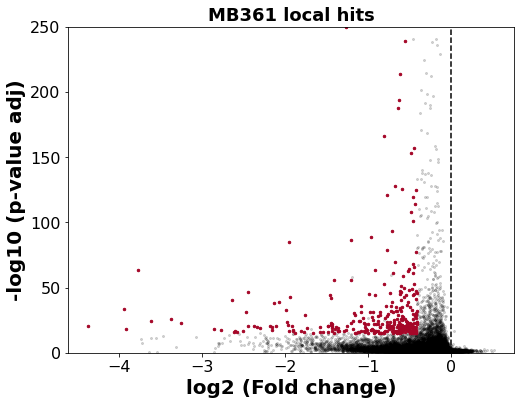

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(np.log2(local_gene_df['fc_by_rand_dist_cpm']),
          -local_gene_df['padj-Gaussian'],
          s=4,
          color='#000000',
          alpha=0.15)

#highlight local hits passing filter 
ax.scatter(np.log2(filter_local_df['fc_by_rand_dist_cpm']),
          -(filter_local_df['padj-Gaussian']),
          s=6,
          color='#A60628')

ax.axvline(0, 
           ls='--', 
           color='#000000')

#label title and axises
ax.set_title('MB361 local hits',
         fontsize=18, fontweight='bold')
#ax.set_xlim([-2,2])
ax.set_ylim([0,250])
ax.set_xlabel('log2 (Fold change)', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, color='#000000')
ax.set_ylabel('-log10 (p-value adj)', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16, color='#000000')
plt.savefig('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB361-GWAS+SM/jupyter_plots/MB361_local_hit_volcano-250_hits-v3.tiff')
#plt.show()

## Distance histogram plot 
____

In [2]:
local_df_columns = ['idx', 'gene_names', 'chromosome', 'pos', 'strand', 
                    'color_idx', 'chr_idx', 'region', 'distance', 'num_cell', 'bin', 
                    'pval', 'fc', 'padj-Gaussian', 'fc_by_rand_dist_cpm']

In [3]:
local_df = pd.read_csv('./MB361-filter_local_df.csv')[local_df_columns]

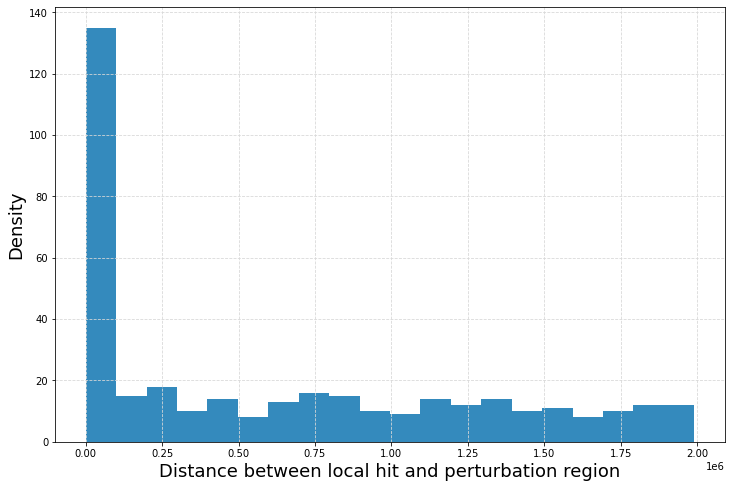

In [6]:
fig, ax = plt.subplots(figsize= (12,8))
ax.grid(ls='--', color='#D8D8D8')

ax.hist(local_df['distance'].values, 
        color='#348ABD',
        bins=20, 
#        alpha=.5
       )

ax.set_ylabel('Density', fontsize=18)
ax.set_xlabel('Distance between local hit and perturbation region', fontsize=18)
plt.savefig('./figures/MB361-local_dist_hist.pdf')